## Homework 2 : Clasifying whether a given tweet is about a real disaster (1) or not (0). Build a LSTM model and a GRU model to predict the tweet.


---
> **Student ID:** 313831002


> **Student Name:** Pavan Kumar J | 柯奉煌

> **Course Name:** Recurrent Neural Networks

> **Instructor:** 黃仁竑 


### Import Statements

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string, re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from functools import reduce
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Embedding, LSTM, GRU, Dropout, 
                                     Bidirectional, GlobalMaxPooling1D)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Load the Dataset

In [2]:
# Replace 'train.csv' with the path to your training data file from Kaggle.
train_data = pd.read_csv('train.csv')

print(train_data.shape)
train_data.head()

(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Text-Cleaning Function

In [3]:
# Basic cleaning (remove punctuation)
def toclean_text(text):
    clean_text = [char for char in text if char not in string.punctuation]
    return ''.join(clean_text)

abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'URL', text)

def remove_HTML(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

def remove_not_ASCII(text):
    return ''.join([char for char in text if char in string.printable])

def word_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

def replace_abbrev(text):
    new_text = ""
    for word in text.split():
        new_text += word_abbrev(word) + " "        
    return new_text

def remove_mention(text):
    at = re.compile(r'@\S+')
    return at.sub(r'USER', text)

def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'NUMBER', text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'EMOJI', text)

def transcription_sad(text):
    smiley = re.compile(r'[8:=;][\'\-]?[(\\/]')
    return smiley.sub(r'SADFACE', text)

def transcription_smile(text):
    smiley = re.compile(r'[8:=;][\'\-]?[)dDp]')
    return smiley.sub(r'SMILE', text)

def transcription_heart(text):
    heart = re.compile(r'<3')
    return heart.sub(r'HEART', text)

def clean_tweet(text):
    text = remove_URL(text)
    text = remove_HTML(text)
    text = remove_not_ASCII(text)
    text = replace_abbrev(text)  
    text = remove_mention(text)
    text = remove_number(text)
    text = remove_emoji(text)
    text = transcription_sad(text)
    text = transcription_smile(text)
    text = transcription_heart(text)
    return text


### Preprocess the Text Data

In [4]:
# First, remove punctuation
train_data['clean_text'] = train_data['text'].apply(toclean_text)

# Then, apply tweet-specific cleaning
train_data['clean_text'] = train_data['clean_text'].apply(clean_tweet)

# Remove stopwords
def toremove_stopword(text):
    # Tokenize the text and remove stopwords
    tokens = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    return " ".join(tokens)

train_data['clean_text'] = train_data['clean_text'].apply(toremove_stopword)
train_data.head()


,id,keyword,location,text,target,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Deeds Reason earthquake May ALLAH Forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,NUMBER people receive wildfires evacuation ord...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo Ruby Alaska smoke wildfires pou...


### Tokenization and Padding

In [5]:
# Set vocabulary size (max_features) and tokenize
max_features = 3000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(train_data['clean_text'].values)

X = tokenizer.texts_to_sequences(train_data['clean_text'].values)
X = pad_sequences(X)  # Pads to the maximum length found in the data.
print("Shape of X:", X.shape)

# Define the target labels.
y = train_data['target']

# Split into training and test sets.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=41)


Shape of X: (7613, 20)


In [6]:
import time, psutil, os
import tensorflow as tf

# Define the custom callback for time and memory tracking.
class EpochTimeMemoryCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []
        self.epoch_memory = []  # Memory change per epoch (MB)
        self.process = psutil.Process(os.getpid())
        self.mem_before_train = self.process.memory_info().rss / (1024 * 1024)  # in MB

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()
        self.mem_start = self.process.memory_info().rss / (1024 * 1024)  # in MB

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        self.epoch_times.append(epoch_time)
        mem_end = self.process.memory_info().rss / (1024 * 1024)  # in MB
        memory_usage = mem_end - self.mem_start
        self.epoch_memory.append(memory_usage)
        print(f"Epoch {epoch+1}: Time = {epoch_time:.2f} s, Memory Change = {memory_usage:.2f} MB")

    def on_train_end(self, logs=None):
        total_time = sum(self.epoch_times)
        final_mem = self.process.memory_info().rss / (1024 * 1024)  # in MB
        total_mem_change = final_mem - self.mem_before_train
        print("\nTraining Summary:")
        print("Epoch-wise times (seconds):", self.epoch_times)
        print("Total training time: {:.2f} seconds".format(total_time))
        print("Epoch-wise memory changes (MB):", self.epoch_memory)
        print("Total memory change during training: {:.2f} MB".format(total_mem_change))

# Create separate instances of the custom callback for each model training
lstm_epoch_callback = EpochTimeMemoryCallback()
gru_epoch_callback = EpochTimeMemoryCallback()
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

# Model hyperparameters
embed_dim = 128        # Embedding dimension
input_length = X.shape[1]  # Length of the input sequences


### Bidirectional LSTM Model

In [7]:
from tensorflow.keras.layers import GlobalMaxPooling1D

model_lstm = Sequential([
    Embedding(max_features, embed_dim, input_length=input_length),
    Dropout(0.3),
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

adam = optimizers.Adam(learning_rate=0.002)
model_lstm.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model_lstm.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Bidirectional GRU Model

In [8]:
model_gru = Sequential([
    Embedding(max_features, embed_dim, input_length=input_length),
    Dropout(0.3),
    Bidirectional(GRU(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_gru.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model_gru.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Training

In [9]:
batch_size = 32
epochs = 10


In [10]:
print("Training the Bidirectional LSTM Model...")
start_time = time.time()
history_lstm = model_lstm.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[reduce_lr, lstm_epoch_callback],
    verbose=1
)
total_lstm_time = time.time() - start_time
print("\n[Overall] Bidirectional LSTM Total Training Time (including overhead): {:.2f} seconds".format(total_lstm_time))


Training the Bidirectional LSTM Model...
Epoch 1/10
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6330 - loss: 0.6299Epoch 1: Time = 4.32 s, Memory Change = 135.13 MB
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6339 - loss: 0.6292 - val_accuracy: 0.8030 - val_loss: 0.4408 - learning_rate: 0.0020
Epoch 2/10
185/191 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8394 - loss: 0.3914Epoch 2: Time = 1.61 s, Memory Change = 4.68 MB
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8391 - loss: 0.3916 - val_accuracy: 0.8076 - val_loss: 0.4387 - learning_rate: 0.0020
Epoch 3/10
188/191 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8799 - loss: 0.3122Epoch 3: Time = 1.64 s, Memory Change = 1.77 MB
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8797 - loss: 0.3125 - val_accuracy: 0.7879 - val_loss: 0.5036 - learning_rate: 0.0020
Epoch 4/10
188/191 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8988 - loss: 0.2607
Epoch 4: ReduceLROnPlateau reducing learning rat

In [11]:
# Define a new optimizer
adam = optimizers.Adam(learning_rate=0.002)

# Compile the GRU model with the new optimizer
model_gru.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

# Now train the model
print("\nTraining the Bidirectional GRU Model...")
start_time = time.time()
history_gru = model_gru.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[reduce_lr, gru_epoch_callback],
    verbose=1
)
total_gru_time = time.time() - start_time
print("\n[Overall] Bidirectional GRU Total Training Time (including overhead): {:.2f} seconds".format(total_gru_time))



Training the Bidirectional GRU Model...
Epoch 1/10
188/191 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6409 - loss: 0.6214Epoch 1: Time = 4.57 s, Memory Change = 96.86 MB
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6426 - loss: 0.6199 - val_accuracy: 0.8188 - val_loss: 0.4360 - learning_rate: 0.0020
Epoch 2/10
188/191 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8467 - loss: 0.3805Epoch 2: Time = 1.65 s, Memory Change = 4.74 MB
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8466 - loss: 0.3808 - val_accuracy: 0.8122 - val_loss: 0.4366 - learning_rate: 0.0020
Epoch 3/10
185/191 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8747 - loss: 0.3090
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.
Epoch 3: Time = 1.61 s, Memory Change = 1.39 MB
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8744 - loss: 0.3095 - val_accuracy: 0.7971 - val_loss: 0.4600 - learning_rate: 0.0020
Epoch 4/10
186/191 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accu

### Evaluate the Models

In [12]:
# For LSTM model
y_pred_lstm = (model_lstm.predict(X_val) > 0.5).astype("int32")
print("Bidirectional LSTM Model Evaluation:")
print("Accuracy: ", metrics.accuracy_score(y_val, y_pred_lstm))
print("Precision:", metrics.precision_score(y_val, y_pred_lstm))
print("Recall:   ", metrics.recall_score(y_val, y_pred_lstm))
print(classification_report(y_val, y_pred_lstm))

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Bidirectional LSTM Model Evaluation:
Accuracy:  0.7728168089297439
Precision: 0.7266081871345029
Recall:    0.7576219512195121
              precision    recall  f1-score   support

           0       0.81      0.78      0.80       867
           1       0.73      0.76      0.74       656

    accuracy                           0.77      1523
   macro avg       0.77      0.77      0.77      1523
weighted avg       0.77      0.77      0.77      1523



In [13]:
# For GRU model
y_pred_gru = (model_gru.predict(X_val) > 0.5).astype("int32")
print("\nBidirectional GRU Model Evaluation:")
print("Accuracy: ", metrics.accuracy_score(y_val, y_pred_gru))
print("Precision:", metrics.precision_score(y_val, y_pred_gru))
print("Recall:   ", metrics.recall_score(y_val, y_pred_gru))
print(classification_report(y_val, y_pred_gru))

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Bidirectional GRU Model Evaluation:
Accuracy:  0.7806959947472094
Precision: 0.7446808510638298
Recall:    0.7469512195121951
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       867
           1       0.74      0.75      0.75       656

    accuracy                           0.78      1523
   macro avg       0.78      0.78      0.78      1523
weighted avg       0.78      0.78      0.78      1523



In [14]:
# Format epoch times and memory changes to 2 decimal places for LSTM
formatted_lstm_epoch_times = [f"{t:.2f}" for t in lstm_epoch_callback.epoch_times]
formatted_lstm_epoch_memory = [f"{m:.2f}" for m in lstm_epoch_callback.epoch_memory]

# Format epoch times and memory changes for GRU
formatted_gru_epoch_times = [f"{t:.2f}" for t in gru_epoch_callback.epoch_times]
formatted_gru_epoch_memory = [f"{m:.2f}" for m in gru_epoch_callback.epoch_memory]

# For LSTM:
print("\nBidirectional LSTM per-epoch timings and memory usage:")
print("Epoch times (s):", formatted_lstm_epoch_times)
print("Epoch memory changes (MB):", formatted_lstm_epoch_memory)
print("\n[Overall] Bidirectional LSTM Total Training Time (including overhead): {:.2f} seconds".format(total_lstm_time))

# For GRU:
print("\nBidirectional GRU per-epoch timings and memory usage:")
print("Epoch times (s):", formatted_gru_epoch_times)
print("Epoch memory changes (MB):", formatted_gru_epoch_memory)
print("\n[Overall] Bidirectional GRU Total Training Time (including overhead): {:.2f} seconds".format(total_gru_time))



Bidirectional LSTM per-epoch timings and memory usage:
Epoch times (s): ['4.32', '1.61', '1.64', '1.66', '1.65', '1.66', '1.68', '1.66', '1.60', '1.74']
Epoch memory changes (MB): ['135.13', '4.68', '1.77', '1.84', '0.62', '0.60', '0.96', '0.51', '0.10', '0.85']

[Overall] Bidirectional LSTM Total Training Time (including overhead): 19.26 seconds

Bidirectional GRU per-epoch timings and memory usage:
Epoch times (s): ['4.57', '1.65', '1.61', '1.78', '1.63', '1.58', '1.62', '1.68', '1.66', '1.58']
Epoch memory changes (MB): ['96.86', '4.74', '1.39', '0.62', '1.48', '0.41', '0.22', '0.03', '0.01', '0.21']

[Overall] Bidirectional GRU Total Training Time (including overhead): 19.41 seconds


### Visualize Training History

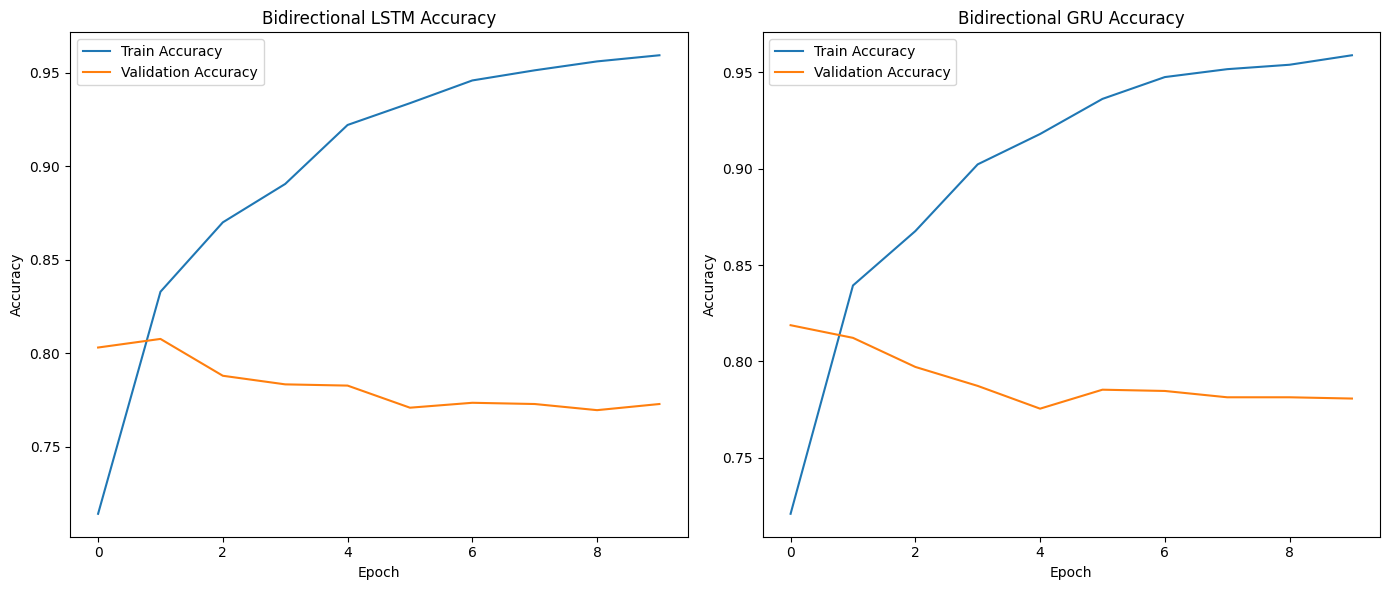

In [15]:
plt.figure(figsize=(14, 6))

# LSTM Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('Bidirectional LSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# GRU Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_gru.history['accuracy'], label='Train Accuracy')
plt.plot(history_gru.history['val_accuracy'], label='Validation Accuracy')
plt.title('Bidirectional GRU Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


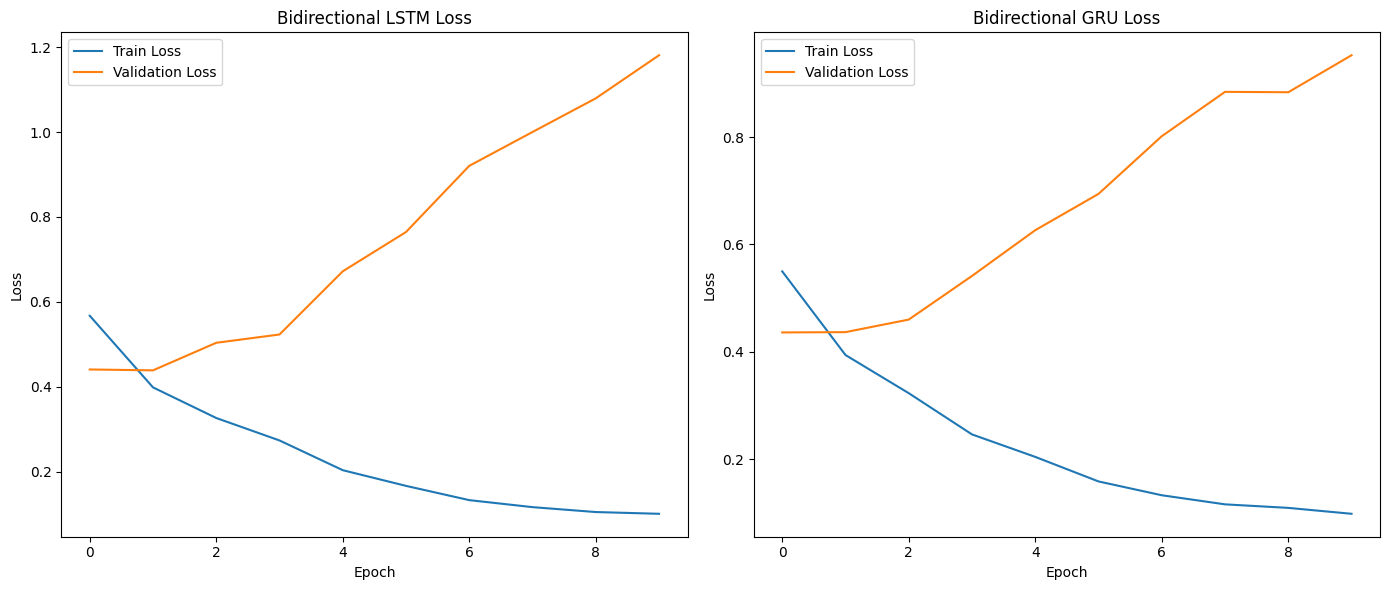

In [16]:
plt.figure(figsize=(14, 6))

# LSTM Loss
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('Bidirectional LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# GRU Loss
plt.subplot(1, 2, 2)
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('Bidirectional GRU Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### Testing

In [19]:
# Load the test dataset. Replace 'test.csv' with your test file location.
test_df = pd.read_csv('test.csv')

# Ensure the text column is lowercase.
test_df['text'] = test_df['text'].apply(lambda x: x.lower())

# Tokenize and pad the test texts using the same tokenizer and max_len as for training.
test_sequences = tokenizer.texts_to_sequences(test_df['text'].values)
test_padded = pad_sequences(test_sequences, maxlen=100, padding='post')

# Generate predictions from both improved models.
lstm_test_predictions = model_lstm.predict(test_padded)
gru_test_predictions = model_gru.predict(test_padded)

# Convert prediction probabilities to binary labels with a threshold of 0.5.
lstm_pred_labels = (lstm_test_predictions > 0.5).astype(int).flatten()
gru_pred_labels = (gru_test_predictions > 0.5).astype(int).flatten()

# Create a DataFrame for the predictions in the required format.
results = pd.DataFrame({
    'ID': test_df['id'],
    'LSTM': lstm_pred_labels,
    'GRU': gru_pred_labels
})

# (Optional) Ensure the predictions are sorted by ID.
results = results.sort_values(by='ID')
results.head()


102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


,ID,LSTM,GRU
0,0,1,1
1,2,1,1
2,3,1,1
3,9,1,1
4,11,1,1


### Saving the prediction into CSV file

In [20]:
# Save the predictions to a CSV file in the required format.
results.to_csv('prediction_results.csv', index=False)
print("Predictions saved to 'prediction_results.csv'.")


Predictions saved to 'prediction_results.csv'.
